In [1]:
from canns.models.brain_inspired import AmariHopfieldNetwork  # :cite:p:`amari1977neural,hopfield1982neural`

# Create a Hopfield network with 16,384 neurons (128x128 flattened image)
model = AmariHopfieldNetwork(
    num_neurons=128 * 128,  # Image size when flattened
    asyn=False,             # Synchronous updates (all neurons update together)
    activation="sign"       # Binary activation: +1 or -1
)

In [2]:
from canns.trainer import HebbianTrainer

trainer = HebbianTrainer(model)

In [4]:
import numpy as np
import skimage.data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_mean

def preprocess_image(img, size=128):
    """Convert image to binary {-1, +1} pattern."""
    # Convert to grayscale if needed
    if img.ndim == 3:
        img = rgb2gray(img)

    # Resize to fixed size
    img = resize(img, (size, size), anti_aliasing=True)

    # Threshold to binary
    thresh = threshold_mean(img)
    binary = img > thresh

    # Map to {-1, +1}
    pattern = np.where(binary, 1.0, -1.0).astype(np.float32)

    # Flatten to 1D
    return pattern.reshape(size * size)

# Load example images from scikit-image
camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

training_data = [camera, astronaut, horse, coffee]

print(f"Number of patterns: {len(training_data)}")
print(f"Pattern shape: {training_data[0].shape}")  # (16384,) = 128*128

Number of patterns: 4
Pattern shape: (16384,)


In [5]:
from canns.models.brain_inspired import AmariHopfieldNetwork  # :cite:p:`amari1977neural,hopfield1982neural`
from canns.trainer import HebbianTrainer

# Create Hopfield network (auto-initializes)
model = AmariHopfieldNetwork(
    num_neurons=training_data[0].shape[0],
    asyn=False,
    activation="sign"
)

# Create Hebbian trainer
trainer = HebbianTrainer(model)

print("Model and trainer initialized!")

Model and trainer initialized!


In [6]:
# Train on all patterns (this computes Hebbian weight matrix)
trainer.train(training_data)

print("Training complete! Patterns stored in weights.")

Training complete! Patterns stored in weights.


In [ ]:
# Simplified version of Hebbian weight update
for pattern in training_data:
    W += np.outer(pattern, pattern)  # Hebbian: w_ij += x_i * x_j
W /= len(training_data)  # Normalize
np.fill_diagonal(W, 0)   # No self-connections

In [8]:
def corrupt_pattern(pattern, noise_level=0.3):
    """Randomly flip 30% of pixels."""
    corrupted = np.copy(pattern)
    num_flips = int(len(pattern) * noise_level)
    flip_indices = np.random.choice(len(pattern), num_flips, replace=False)
    corrupted[flip_indices] *= -1  # Flip sign
    return corrupted

# Create test patterns (30% corrupted)
test_patterns = [corrupt_pattern(p, 0.3) for p in training_data]

print(f"Created {len(test_patterns)} corrupted test patterns")

Created 4 corrupted test patterns


In [9]:
# Batch prediction (compiled for efficiency)
recalled = trainer.predict_batch(test_patterns, show_sample_progress=True)

print("Pattern recall complete!")
print(f"Recalled patterns shape: {np.array(recalled).shape}")

Processing samples: 100%|█████████████| 4/4 [00:04<00:00,  1.15s/it, sample=4/4]


Pattern recall complete!
Recalled patterns shape: (4, 16384)


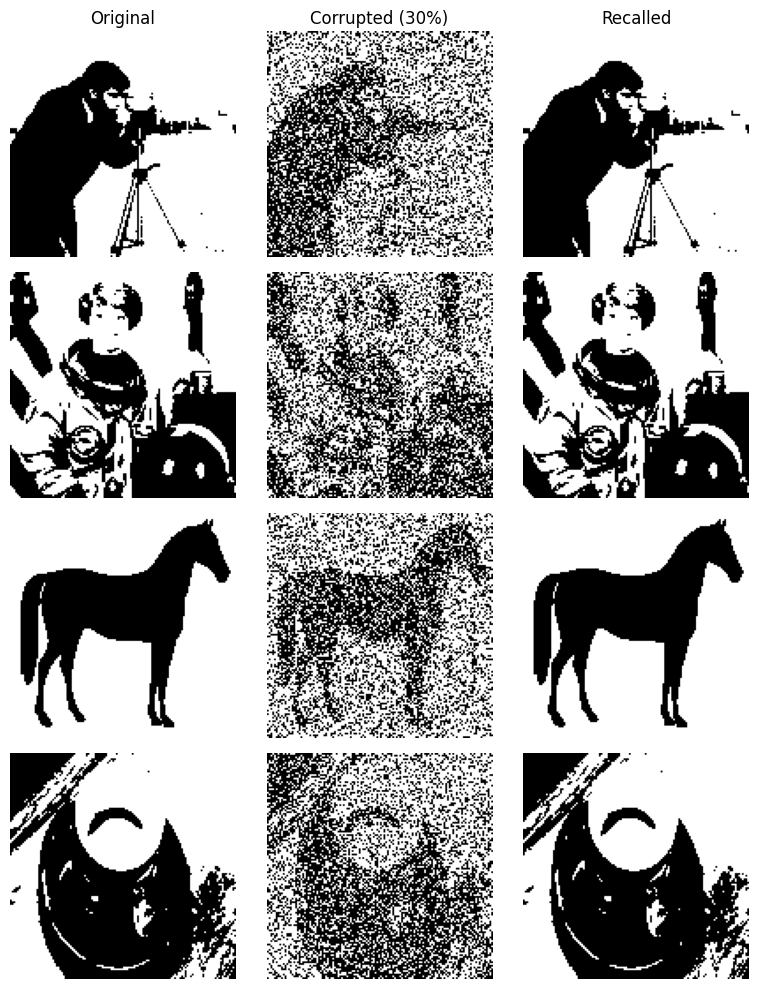

Visualization saved!


In [10]:
import matplotlib.pyplot as plt

def reshape_for_display(pattern, size=128):
    """Reshape 1D pattern back to 2D image."""
    return pattern.reshape(size, size)

# Plot original, corrupted, and recalled patterns
fig, axes = plt.subplots(len(training_data), 3, figsize=(8, 10))

for i in range(len(training_data)):
    # Column 1: Original training image
    axes[i, 0].imshow(reshape_for_display(training_data[i]), cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title('Original')

    # Column 2: Corrupted test input
    axes[i, 1].imshow(reshape_for_display(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title('Corrupted (30%)')

    # Column 3: Recalled output
    axes[i, 2].imshow(reshape_for_display(recalled[i]), cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title('Recalled')

plt.tight_layout()
plt.savefig('hopfield_memory_recall.png', dpi=150)
plt.show()

print("Visualization saved!")

In [ ]:
import numpy as np
import skimage.data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_mean
from matplotlib import pyplot as plt

from canns.models.brain_inspired import AmariHopfieldNetwork  # :cite:p:`amari1977neural,hopfield1982neural`
from canns.trainer import HebbianTrainer

np.random.seed(42)

# 1. Preprocess images
def preprocess_image(img, size=128):
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, (size, size), anti_aliasing=True)
    thresh = threshold_mean(img)
    binary = img > thresh
    pattern = np.where(binary, 1.0, -1.0).astype(np.float32)
    return pattern.reshape(size * size)

camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

training_data = [camera, astronaut, horse, coffee]

# 2. Create model and trainer (auto-initializes)
model = AmariHopfieldNetwork(num_neurons=training_data[0].shape[0], asyn=False, activation="sign")
trainer = HebbianTrainer(model)

# 3. Train
trainer.train(training_data)

# 4. Create corrupted test patterns
def corrupt_pattern(pattern, noise_level=0.3):
    corrupted = np.copy(pattern)
    num_flips = int(len(pattern) * noise_level)
    flip_indices = np.random.choice(len(pattern), num_flips, replace=False)
    corrupted[flip_indices] *= -1
    return corrupted

test_patterns = [corrupt_pattern(p, 0.3) for p in training_data]

# 5. Recall patterns
recalled = trainer.predict_batch(test_patterns, show_sample_progress=True)

# 6. Visualize
def reshape(pattern, size=128):
    return pattern.reshape(size, size)

fig, axes = plt.subplots(len(training_data), 3, figsize=(8, 10))
for i in range(len(training_data)):
    axes[i, 0].imshow(reshape(training_data[i]), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(reshape(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(reshape(recalled[i]), cmap='gray')
    axes[i, 2].axis('off')

axes[0, 0].set_title('Original')
axes[0, 1].set_title('Corrupted')
axes[0, 2].set_title('Recalled')

plt.tight_layout()
plt.savefig('hopfield_memory.png')
plt.show()

In [ ]:
# All trainers follow this pattern
trainer = SomeTrainer(model)
trainer.train(data)
output = trainer.predict(input)